In [1]:
import os
import re

import shutil
import codecs, json 
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from scipy import stats
import sklearn as sk
import time
from dypac import Dypac
import nilearn
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr
import nilearn.plotting as plotting
import feature_selec_functions
import csv

import hcp_utils as hcp

import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.connectivity import spectral_connectivity
from mne.viz import circular_layout, plot_connectivity_circle

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


# Load results for plotting

In [164]:
#path to Flanker Task results
path_F = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/df_F.csv'
df_F = pd.read_csv(path_F)

#path to delay Discount results
path_DD = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/df_DD.csv'
df_DD = pd.read_csv(path_DD)

#path to delay Discount results
path_MC = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/df_MC.csv'
df_MC = pd.read_csv(path_MC)

#path to nodes_map 
path_nodes = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/nodes_map.csv'

In [174]:
#path to parcellation labels 
path_label = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/Parcellations/Parcellations/HCP/fslr32k/cifti/Schaefer2018_100Parcels_7Networks_order_info.txt'

with open(path_label, 'r') as f:
    lines = f.readlines()
    
lines

['7Networks_LH_Vis_1\n',
 '1 120 18 131 255\n',
 '7Networks_LH_Vis_2\n',
 '2 120 18 132 255\n',
 '7Networks_LH_Vis_3\n',
 '3 120 18 133 255\n',
 '7Networks_LH_Vis_4\n',
 '4 120 18 135 255\n',
 '7Networks_LH_Vis_5\n',
 '5 120 18 136 255\n',
 '7Networks_LH_Vis_6\n',
 '6 120 18 137 255\n',
 '7Networks_LH_Vis_7\n',
 '7 120 18 138 255\n',
 '7Networks_LH_Vis_8\n',
 '8 120 18 139 255\n',
 '7Networks_LH_Vis_9\n',
 '9 120 18 140 255\n',
 '7Networks_LH_SomMot_1\n',
 '10 70 130 179 255\n',
 '7Networks_LH_SomMot_2\n',
 '11 70 130 181 255\n',
 '7Networks_LH_SomMot_3\n',
 '12 70 130 182 255\n',
 '7Networks_LH_SomMot_4\n',
 '13 70 130 183 255\n',
 '7Networks_LH_SomMot_5\n',
 '14 70 130 184 255\n',
 '7Networks_LH_SomMot_6\n',
 '15 70 130 185 255\n',
 '7Networks_LH_DorsAttn_Post_1\n',
 '16 0 118 13 255\n',
 '7Networks_LH_DorsAttn_Post_2\n',
 '17 0 118 15 255\n',
 '7Networks_LH_DorsAttn_Post_3\n',
 '18 0 118 16 255\n',
 '7Networks_LH_DorsAttn_Post_4\n',
 '19 0 118 17 255\n',
 '7Networks_LH_DorsAttn_Post

In [175]:
#list of parcels
list_parcel = []
for i in range(0, len(lines), 2): #only even rows
    list_parcel.append(lines[i][10:-1])
#len(list_parcel)
list_parcel

['LH_Vis_1',
 'LH_Vis_2',
 'LH_Vis_3',
 'LH_Vis_4',
 'LH_Vis_5',
 'LH_Vis_6',
 'LH_Vis_7',
 'LH_Vis_8',
 'LH_Vis_9',
 'LH_SomMot_1',
 'LH_SomMot_2',
 'LH_SomMot_3',
 'LH_SomMot_4',
 'LH_SomMot_5',
 'LH_SomMot_6',
 'LH_DorsAttn_Post_1',
 'LH_DorsAttn_Post_2',
 'LH_DorsAttn_Post_3',
 'LH_DorsAttn_Post_4',
 'LH_DorsAttn_Post_5',
 'LH_DorsAttn_Post_6',
 'LH_DorsAttn_PrCv_1',
 'LH_DorsAttn_FEF_1',
 'LH_SalVentAttn_ParOper_1',
 'LH_SalVentAttn_FrOperIns_1',
 'LH_SalVentAttn_FrOperIns_2',
 'LH_SalVentAttn_PFCl_1',
 'LH_SalVentAttn_Med_1',
 'LH_SalVentAttn_Med_2',
 'LH_SalVentAttn_Med_3',
 'LH_Limbic_OFC_1',
 'LH_Limbic_TempPole_1',
 'LH_Limbic_TempPole_2',
 'LH_Cont_Par_1',
 'LH_Cont_PFCl_1',
 'LH_Cont_pCun_1',
 'LH_Cont_Cing_1',
 'LH_Default_Temp_1',
 'LH_Default_Temp_2',
 'LH_Default_Par_1',
 'LH_Default_Par_2',
 'LH_Default_PFC_1',
 'LH_Default_PFC_2',
 'LH_Default_PFC_3',
 'LH_Default_PFC_4',
 'LH_Default_PFC_5',
 'LH_Default_PFC_6',
 'LH_Default_PFC_7',
 'LH_Default_pCunPCC_1',
 'LH_Defa

In [170]:
from csv import reader
# read csv file as a list of lists
with open(path_nodes, 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    nodes_map = reader(read_obj)
    # Pass reader object to list() to get a list of lists
    nodes_map = list(nodes_map)
    print(nodes_map)

[['0', '1'], ['0', '2'], ['0', '3'], ['0', '4'], ['0', '5'], ['0', '6'], ['0', '7'], ['0', '8'], ['0', '9'], ['0', '10'], ['0', '11'], ['0', '12'], ['0', '13'], ['0', '14'], ['0', '15'], ['0', '16'], ['0', '17'], ['0', '18'], ['0', '19'], ['0', '20'], ['0', '21'], ['0', '22'], ['0', '23'], ['0', '24'], ['0', '25'], ['0', '26'], ['0', '27'], ['0', '28'], ['0', '29'], ['0', '30'], ['0', '31'], ['0', '32'], ['0', '33'], ['0', '34'], ['0', '35'], ['0', '36'], ['0', '37'], ['0', '38'], ['0', '39'], ['0', '40'], ['0', '41'], ['0', '42'], ['0', '43'], ['0', '44'], ['0', '45'], ['0', '46'], ['0', '47'], ['0', '48'], ['0', '49'], ['0', '50'], ['0', '51'], ['0', '52'], ['0', '53'], ['0', '54'], ['0', '55'], ['0', '56'], ['0', '57'], ['0', '58'], ['0', '59'], ['0', '60'], ['0', '61'], ['0', '62'], ['0', '63'], ['0', '64'], ['0', '65'], ['0', '66'], ['0', '67'], ['0', '68'], ['0', '69'], ['0', '70'], ['0', '71'], ['0', '72'], ['0', '73'], ['0', '74'], ['0', '75'], ['0', '76'], ['0', '77'], ['0', '

In [171]:
range(len(nodes_map))

range(0, 4950)

In [177]:
int(nodes_map[0][0])

0

In [178]:
#create a list of dictionaries which identifies each relevant pair of nodes 
res = []
for i in range(len(nodes_map)):
    dict_res = {}
    lis = nodes_map[i]
    parcel_index = int(lis[0]) #tupples and list_parcels are listed from zero
    dict_res["node1"] = list_parcel[parcel_index]
    parcel_index = int(lis[1])
    dict_res["node2"] = list_parcel[parcel_index]
    res.append(dict_res)
res

[{'node1': 'LH_Vis_1', 'node2': 'LH_Vis_2'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_Vis_3'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_Vis_4'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_Vis_5'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_Vis_6'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_Vis_7'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_Vis_8'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_Vis_9'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_SomMot_1'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_SomMot_2'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_SomMot_3'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_SomMot_4'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_SomMot_5'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_SomMot_6'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_DorsAttn_Post_1'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_DorsAttn_Post_2'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_DorsAttn_Post_3'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_DorsAttn_Post_4'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_DorsAttn_Post_5'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_DorsAttn_Post_6'},
 {'node1': 'LH_Vis_1',

In [179]:
df_nodes = pd.DataFrame(res)
df_nodes

,node1,node2
0,LH_Vis_1,LH_Vis_2
1,LH_Vis_1,LH_Vis_3
2,LH_Vis_1,LH_Vis_4
3,LH_Vis_1,LH_Vis_5
4,LH_Vis_1,LH_Vis_6
...,...,...
4945,RH_Default_PFCdPFCm_2,RH_Default_pCunPCC_1
4946,RH_Default_PFCdPFCm_2,RH_Default_pCunPCC_2
4947,RH_Default_PFCdPFCm_3,RH_Default_pCunPCC_1
4948,RH_Default_PFCdPFCm_3,RH_Default_pCunPCC_2


In [70]:
df_DD

,Unnamed: 0,node1,node2,beta
0,0,LH_Vis_1,RH_Cont_pCun_1,-0.048546
1,1,LH_Vis_2,RH_Vis_1,0.034306
2,2,LH_Vis_3,LH_DorsAttn_Post_3,-0.027305
3,3,LH_Vis_3,RH_Vis_7,-0.027874
4,4,LH_Vis_3,RH_DorsAttn_Post_4,-0.035309
...,...,...,...,...
118,118,RH_Cont_Par_1,RH_Cont_PFCl_2,0.052396
119,119,RH_Cont_PFCl_1,RH_Cont_PFCl_2,0.091222
120,120,RH_Cont_Cing_1,RH_Default_Temp_2,0.045996
121,121,RH_Cont_Cing_1,RH_Default_Temp_3,0.032650


In [151]:
df = df_MC
node_names = list(df.node1) + list(df.node2)
node_names = list(set(node_names))
con = df.beta


In [181]:
len(df)
df = df.sort_values(by=['beta'], ascending=False)

df

,Unnamed: 0,node1,node2,beta
19,19,LH_Vis_7,LH_Vis_8,0.028673
10,10,LH_Vis_5,LH_DorsAttn_Post_5,0.027729
51,51,LH_Cont_Par_1,LH_Default_Par_1,0.027483
64,64,LH_Default_PFC_1,RH_Default_PFCv_1,0.023571
9,9,LH_Vis_5,LH_Vis_7,0.023564
...,...,...,...,...
87,87,LH_Default_PFC_7,RH_Default_pCunPCC_2,-0.018149
80,80,LH_Default_PFC_6,RH_Cont_Par_1,-0.018769
86,86,LH_Default_PFC_7,RH_Default_Par_1,-0.019118
93,93,RH_Vis_4,RH_Cont_Par_1,-0.021604


In [20]:
name = 'RH_Default_Temp_2'
net = name.split('_')[1]
net

'Default'

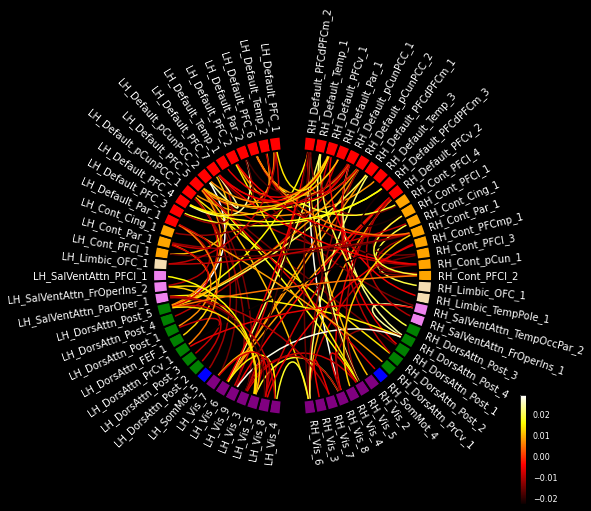

(<Figure size 720x720 with 2 Axes>, <PolarAxesSubplot:>)

In [155]:
i_1 = []
i_2 = []
for f in range(len(df)):
    feature = df.iloc[f,:]
    i_1.append(node_names.index(feature['node1']))
    i_2.append(node_names.index(feature['node2']))
indices = (np.array(i_1), np.array(i_2))

lh_names = [name for name in node_names if 'LH' in name]
rh_names = [name for name in node_names if 'RH' in name]
lh_ordered = []
rh_ordered = []
net_names = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
for network in net_names: 
    lh_net_names = [name for name in lh_names if network in name]
    lh_ordered = lh_ordered + lh_net_names

    rh_net_names = [name for name in rh_names if network in name]
    rh_ordered = rh_ordered + rh_net_names
lh_ordered.reverse()
ordered = lh_ordered + rh_ordered

layout = circular_layout(node_names=node_names, node_order=ordered, group_boundaries=[0, len(lh_ordered)])
colors_list = ['purple', 'blue', 'green', 'violet', 'wheat', 'orange', 'red']
#colors_list = [(120/255, 18/255, 133/255), (70/255, 130/255, 180/255), (0/255, 118/255, 14/255), (196/255, 57/255, 248/255), (220/255, 248/255, 162/255), (230/255, 146/255, 32/255), (204/255, 60/255, 78/255)]

color_dict = dict(zip(net_names, colors_list))
node_colors = []
for name in node_names:
    net = name.split('_')[1]
    node_colors.append(color_dict[net])
    

fig = plt.figure(figsize=[10,10], facecolor='black')
plot_connectivity_circle(con, node_names, indices ,fontsize_names=10, n_lines=200,
                         textcolor='white', facecolor='black', node_angles=layout, 
                        node_colors=node_colors, fig=fig, colorbar=True)

In [130]:
import plot_con_helper
import importlib

importlib.reload(plot_con_helper)


#Plot results of all 3 tasks
dfs = ['df_DD', 'df_F', 'df_MC']

node_names_lis = []
con_lis = []
indices_lis = []
ordered_lis = []
node_colors_lis = []
layout_lis = []

for i in range(len(dfs)):
    path = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/{}.csv'.format(dfs[i])
    df = pd.read_csv(path)
    node_names, con, indices, ordered, node_colors, layout = plot_con_helper.plot_con_helper(df)
    node_names_lis.append(node_names)
    con_lis.append(con)
    indices_lis.append(indices)
    ordered_lis.append(ordered)
    node_colors_lis.append(node_colors)
    layout_lis.append(layout)
    

In [100]:
layout_lis[1]

array([222.5       , 277.02380952, 402.5       , 262.97619048,
       194.16666667, 238.69047619, 317.5       , 341.78571429,
       357.97619048, 345.83333333, 366.07142857, 281.07142857,
       349.88095238, 141.54761905, 370.11904762, 137.5       ,
       374.16666667, 190.11904762, 378.21428571, 169.88095238,
       165.83333333, 186.07142857, 258.92857143, 157.73809524,
       218.45238095, 353.92857143, 406.54761905, 214.4047619 ,
       410.5952381 , 321.54761905, 414.64285714, 325.5952381 ,
       301.30952381, 234.64285714, 329.64285714, 254.88095238,
       182.02380952, 285.11904762, 418.69047619, 422.73809524,
       426.78571429, 177.97619048, 382.26190476, 250.83333333,
       230.5952381 , 430.83333333, 210.35714286, 333.69047619,
       246.78571429, 133.45238095, 434.88095238, 129.4047619 ,
       386.30952381, 206.30952381, 337.73809524, 438.92857143,
       153.69047619, 390.35714286, 289.16666667, 149.64285714,
       125.35714286, 305.35714286, 362.02380952, 202.26

In [72]:
dfs = ['df_DD', 'df_F', 'df_MC']
df = dfs[0]
df

'df_DD'

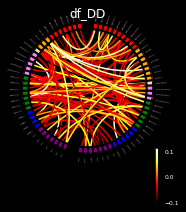

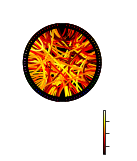

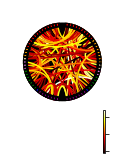

In [145]:
#Plot results of all 3 tasks

fig = plt.figure(num=None, figsize=(10, 5), facecolor='black')
#no_names = [''] * len(label_names)
for ii, df in enumerate(dfs):
    plot_connectivity_circle(con_lis[ii], node_names_lis[ii], indices_lis[ii] ,fontsize_names=0, n_lines=200,
                              textcolor='white', facecolor='black', node_angles=layout_lis[ii], 
                             node_colors=node_colors_lis[ii],
                             title=df, padding=0, fontsize_colorbar=6,
                             fig=fig, subplot=(1, 3, ii + 1))
     
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'plot_connectivity_circle'

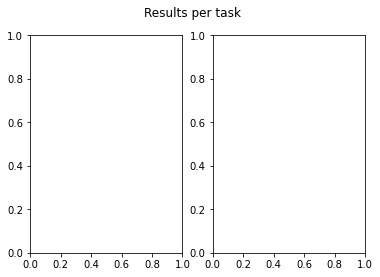

<Figure size 720x360 with 0 Axes>

In [140]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Results per task')
fig = plt.figure(figsize=[10,5], facecolor='black')
ax1.plot_connectivity_circle(con_lis[0], node_names_lis[0], indices_lis[0] ,fontsize_names=0, n_lines=200,
                         textcolor='white', facecolor='black', node_angles=layout_lis[0], 
                        node_colors=node_colors_lis[0], fig=fig, colorbar=True)
ax2.plot_connectivity_circle(con_lis[1], node_names_lis[1], indices_lis[1] ,fontsize_names=0, n_lines=200,
                         textcolor='white', facecolor='black', node_angles=layout_lis[1], 
                        node_colors=node_colors_lis[1], fig=fig, colorbar=True)


for ax in fig.get_axes():
    ax.label_outer()

# Find common edges between tasks

In [69]:
import plot_con_helper
import importlib

importlib.reload(plot_con_helper)

dfs = ['df_DD', 'df_F']
df_arranged = {}
for i in range(len(dfs)):
    path = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/{}.csv'.format(dfs[i])
    df = pd.read_csv(path)
    df_arranged[i] = plot_con_helper.arrange_df(df)



In [65]:
range(df_arranged[0].shape[0])


range(0, 50)

In [52]:
df_arranged[0].loc[0]['node1'].split('_')[1]

'Cont'

In [70]:
df_arranged[0]

,Unnamed: 0,node1,node2,beta,beta_abs,node1_nets,node2_nets
0,84,LH_Cont_Cing_1,RH_SalVentAttn_TempOccPar_1,0.115238,0.115238,Cont,SalVentAttn
1,113,RH_SalVentAttn_TempOccPar_1,RH_SalVentAttn_FrOperIns_1,0.113757,0.113757,SalVentAttn,SalVentAttn
2,77,LH_Cont_pCun_1,RH_SalVentAttn_TempOccPar_1,0.110846,0.110846,Cont,SalVentAttn
3,85,LH_Cont_Cing_1,RH_Cont_PFCl_2,0.103860,0.103860,Cont,Cont
4,8,LH_Vis_4,RH_Cont_PFCmp_1,0.102704,0.102704,Vis,Cont
5,122,RH_Default_Par_1,RH_Default_PFCv_1,0.102490,0.102490,Default,Default
6,96,LH_Default_PFC_7,RH_Default_PFCdPFCm_2,-0.101949,0.101949,Default,Default
7,6,LH_Vis_4,LH_Cont_Cing_1,0.100199,0.100199,Vis,Cont
8,116,RH_SalVentAttn_TempOccPar_1,RH_Cont_Cing_1,0.094560,0.094560,SalVentAttn,Cont
9,86,LH_Cont_Cing_1,RH_Cont_PFCl_3,0.094280,0.094280,Cont,Cont


In [44]:
type(df_arranged[0])

pandas.core.frame.DataFrame

In [55]:
df_arranged[1]['node2'].split('_')[1] 

AttributeError: 'Series' object has no attribute 'split'

In [50]:
#Compare specific networks
res = []
for i in range(df_arranged[0].shape[0]):
    #print(i)
    node1_val = df_arranged[0].loc[i]['node1']
    node2_val = df_arranged[0].loc[i]['node2']
    #print(node1_val)
    res_tmp = df_arranged[1][(df_arranged[1]['node1'] == node1_val) & (df_arranged[1]['node2'] == node2_val)]
    if res_tmp.shape[0] == 0:
        res_tmp = df_arranged[1][(df_arranged[1]['node2'] == node1_val) & (df_arranged[1]['node1'] == node2_val)]
    if res_tmp.shape[0] == 0:
        continue
    res.append([node1_val, node2_val])

In [51]:
res

[['LH_Vis_4', 'RH_Cont_PFCl_3']]

In [73]:
#Compare only 7 networks
res = []
for i in range(df_arranged[0].shape[0]):
    #print(i)
    node1_org = df_arranged[0].loc[i]['node1']
    node1_val = node1_org.split('_')[1]
    node2_org = df_arranged[0].loc[i]['node2']
    node2_val = node2_org.split('_')[1]
    #print(node1_val)
    res_tmp = df_arranged[1][(df_arranged[1]['node1_nets'] == node1_val) & (df_arranged[1]['node2_nets'] == node2_val)]
    if res_tmp.shape[0] == 0:
        res_tmp = df_arranged[1][(df_arranged[1]['node2_nets'] == node1_val) & (df_arranged[1]['node1_nets'] == node2_val)]
    if res_tmp.shape[0] == 0:
        continue
    res.append([node1_org, node2_org])

In [75]:
union = pd.concat([df_arranged[0], df_arranged[1]])

In [82]:
union

,Unnamed: 0,node1,node2,beta,beta_abs,node1_nets,node2_nets
0,84,LH_Cont_Cing_1,RH_SalVentAttn_TempOccPar_1,0.115238,0.115238,Cont,SalVentAttn
1,113,RH_SalVentAttn_TempOccPar_1,RH_SalVentAttn_FrOperIns_1,0.113757,0.113757,SalVentAttn,SalVentAttn
2,77,LH_Cont_pCun_1,RH_SalVentAttn_TempOccPar_1,0.110846,0.110846,Cont,SalVentAttn
3,85,LH_Cont_Cing_1,RH_Cont_PFCl_2,0.103860,0.103860,Cont,Cont
4,8,LH_Vis_4,RH_Cont_PFCmp_1,0.102704,0.102704,Vis,Cont
...,...,...,...,...,...,...,...
45,14,LH_Vis_6,LH_Cont_PFCl_1,0.177010,0.177010,Vis,Cont
46,15,LH_Vis_6,RH_Vis_7,0.174169,0.174169,Vis,Vis
47,35,LH_DorsAttn_Post_1,LH_Default_PFC_6,0.170532,0.170532,DorsAttn,Default
48,51,LH_Limbic_OFC_1,LH_Cont_Cing_1,0.169499,0.169499,Limbic,Cont


In [84]:
unique_sum = union.groupby(['node1', 'node2'])
unique_sum

In [87]:
union.groupby(['node1_nets', 'node2_nets']).ngroups

27

In [88]:
len(res)

43

In [66]:
node1_nets = []
for val in df_arranged[0]['node1']:
    #print(val)
    net = val.split('_')[1]
    node1_nets.append(net)
node1_nets



['Cont',
 'SalVentAttn',
 'Cont',
 'Cont',
 'Vis',
 'Default',
 'Default',
 'Vis',
 'SalVentAttn',
 'Cont',
 'DorsAttn',
 'Cont',
 'Cont',
 'SalVentAttn',
 'Vis',
 'Vis',
 'Cont',
 'DorsAttn',
 'Vis',
 'SalVentAttn',
 'Cont',
 'SalVentAttn',
 'Cont',
 'Cont',
 'Cont',
 'Cont',
 'SalVentAttn',
 'Default',
 'SalVentAttn',
 'Cont',
 'DorsAttn',
 'DorsAttn',
 'Default',
 'DorsAttn',
 'SomMot',
 'SalVentAttn',
 'Cont',
 'Cont',
 'DorsAttn',
 'Cont',
 'Cont',
 'DorsAttn',
 'Vis',
 'Cont',
 'DorsAttn',
 'DorsAttn',
 'Cont',
 'DorsAttn',
 'Vis',
 'DorsAttn']

In [67]:
df_arranged[0]['node1_nets'] = node1_nets

In [68]:
df_arranged[0]['node1_nets']

0            Cont
1     SalVentAttn
2            Cont
3            Cont
4             Vis
5         Default
6         Default
7             Vis
8     SalVentAttn
9            Cont
10       DorsAttn
11           Cont
12           Cont
13    SalVentAttn
14            Vis
15            Vis
16           Cont
17       DorsAttn
18            Vis
19    SalVentAttn
20           Cont
21    SalVentAttn
22           Cont
23           Cont
24           Cont
25           Cont
26    SalVentAttn
27        Default
28    SalVentAttn
29           Cont
30       DorsAttn
31       DorsAttn
32        Default
33       DorsAttn
34         SomMot
35    SalVentAttn
36           Cont
37           Cont
38       DorsAttn
39           Cont
40           Cont
41       DorsAttn
42            Vis
43           Cont
44       DorsAttn
45       DorsAttn
46           Cont
47       DorsAttn
48            Vis
49       DorsAttn
Name: node1_nets, dtype: object